# [Tutorial](https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/random_forest.ipynb)

# Surface observation postprocessing 


In these notebooks we try some machine learning techniques on a real world simple problem.

We are trying to improve the ECMWF forecast of surface temperature, by doing postprocessing. 

Specifically, we are trying to predict the difference between station observations 2m-temperature and the forecast prediction at the nearest gridpoint to the observation location. This is a regression task.

If we can accurately predict this difference (the forecast error) we can compensate for it, making the forecast more accurate.

We will explore several physically motivated predictors.

We recommend starting with the linear regression notebook.

Note this example of using machine learning to model weather forecast error based on work by Fenwick Cooper funded by <a href="https://www.ifabfoundation.org/">IFAB</a>, the full study can be found <a href="https://www.ecmwf.int/en/elibrary/81297-statistical-modelling-2m-temperature-and-10m-wind-speed-forecast-errors">here</a>.

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/random_forest.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
    <th><a href="https://deepnote.com/launch?url=https://github.com/ecmwf-projects/mooc-machine-learning-weather-climate/blob/main/tier_2/regression_decision_trees/random_forest.ipynb">
        <img src = "https://deepnote.com/buttons/launch-in-deepnote-small.svg" alt = "Kaggle"></th>
  </tr>
</table>

## Using random forests

A quick reminder of the technique. Hopefully you've watched the webinar to have a full explanation.

First, consider a decision tree, which behaves much like a flow chart. Decision trees partition our input data, through a series of binary decisions, e.g. temperature >= 0 or temperature < 0. Each of these decisions creates two branches. 

For each branch, there is another decision to further split the data, until some criteria is met, for example, if each branch has one example, or the number of decisions in the tree meets some threshold. These decisions are automatically designed to optimally partition the data.

During prediction, for your given input data you pass through these branches until you hit the end point. For a regression decision tree, the output is then the value (or average of values) from the subset of the training data which belongs to this node (i.e. made the same decisions as your prediction data). 

A random forest is a collection of decision trees, purposely designed to differ from one another, where the final answer is the average of the prediction from all the decision trees.

Random forests are a powerful tool, particularly for learning "tabular" data.

We will see below how this threshold-based approach creates a "blocky" prediction space, but one that performs well on many error metrics.

In [1]:
#Install the package for our dataset
!pip install "climetlab-mltc-surface-observation-postprocessing>=0.3.0" --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.5/177.5 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 89.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 108.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 86.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ..

In [2]:
# First import the tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.pyplot as plt

# Import a tool to help make figures
from climetlab_mltc_surface_observation_postprocessing.utils import imgBufferFromVectors

# CliMetLab will be used to manage the data loading.
import climetlab as cml

In [3]:
# Load a list of 36 hour forecast errors for 2m temperature.
# Forecast error is the difference between the observation and the forecast prediction.
# The forecasts come from ECMWF's high resolution forecast system.
# The measurements come from around 8000 weather stations around the world.
forecast_error = cml.load_dataset('mltc-surface-observation-postprocessing',field='forecast_error').to_numpy()

# We suspect that the errors in the forecast can be explained simply by the time of day.

# Load the local time of day corresponding to when the measurements were made.
time_of_day = cml.load_dataset('mltc-surface-observation-postprocessing',field='time_of_day').to_numpy()

# Later we will add in the soil temperature
soil_temperature = cml.load_dataset('mltc-surface-observation-postprocessing',field='soil_temperature').to_numpy()

# Note that an important step of data preprocessing has already been carried out in the curation of the dataset.
# Spurious data has already been removed from the dataset based upon a range of categories,
# e.g. stations with inconsistent measurement locations, repeated values, or even physically 
# invalid numbers (>100C).
# If you are starting on a new project this is a key step to clean the data.

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


forecast_error.csv:   0%|          | 0.00/88.3M [00:00<?, ?B/s]

time_of_day.csv:   0%|          | 0.00/92.9M [00:00<?, ?B/s]

soil_temperature.csv:   0%|          | 0.00/87.8M [00:00<?, ?B/s]

In [4]:
# Split each of the predictands and predictors in a random train/test split.
# We use 80% of the data for training & 20% for testing

# Here the data has already been anonymised, so we cannot use information about
# stations or time to ensure independence of our dataset.
# With more meta-data we should follow the lessons learnt in tier-2 on data splitting
# and ensure the data subsets are independent.

# We don't plan to explore hyperparameter space, so a validation set is not required.

(forecast_error_train, forecast_error_test, 
    time_of_day_train, time_of_day_test, 
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error, #the variables to split
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2, #what proportion of the data to use in the test set
                                                                       random_state = 42, #set the random seed for reproducibility
                                                                      )

Next we're going to train a model. 

**Note this took 2 minutes for me**, so maybe time to get a coffee or a snack.

In [5]:
Y_1D = forecast_error_train[...,0]
Y_1D.shape

(4212390,)

In [6]:
%%time
# The line above will time how long it takes to excute this block 

# Label the input & output data, Random Forest likes a 1D vector to predict.
X = time_of_day_train
Y = forecast_error_train[...,0]

# Create the Random Forest regression object
# we limit the complexity of the model by selecting a maximum depth of the trees
# you could explore how this change affects the results.
reg = RandomForestRegressor(n_estimators = 10, # The number of trees in the forest
                            max_depth = 10, # the maximum depth any tree is allowed to have
                            )

# Train the model using the data
# we task it to find the best fit for the forecast errors given a cubic relationship.
reg.fit(X, Y)

CPU times: user 46.1 s, sys: 140 ms, total: 46.3 s
Wall time: 46.2 s


RandomForestRegressor(max_depth=10, n_estimators=10)

In [7]:
# Let's evaluate our model, using root-mean-squared-error (RMSE) and mean-absolute-error (MAE)

# To establish a baseline let's find out the RMSE and MAE of the existing predictions.
# Our baseline is no error correction, or a correction of 0.
zero_test = 0.0*forecast_error_test

#Calculate the MAE
baseline_mae = metrics.mean_absolute_error(zero_test, forecast_error_test)
#Calculate the RMSE
baseline_rmse = np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test))
print('Mean Absolute Error Uncorrected:', baseline_mae)
print('Root Mean Squared Error Uncorrected:', baseline_rmse)


Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456


In [8]:
#Build our input array for the test data, then make a prediction with our model
X_test = time_of_day_test

forecast_corrected = reg.predict(X_test)

corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )


Mean Absolute Error Corrected: 1.5548270564627338
Root Mean Squared Error Corrected: 2.1650328550506233
% Improvement MAE over raw forecast 4.750655778252109
% Improvement RMSE over raw forecast 4.037984813519543


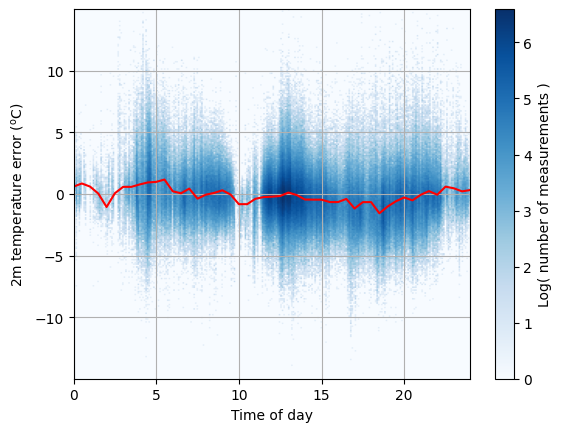

In [9]:
# Predict the outputs for all values between 0 & 24.
x = np.linspace(0, 24, 49)[...,np.newaxis]
y = reg.predict(x)

# Make a graph of the time of day against the forecast error.
# This function helps us build an image of the results
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel('2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x,y,'red')

plt.show()

The model (red line) is better than nothing, but cannot account for the variation in 2m temperature error at single time of day (eg. at 14:00).

Does this look like a sensible model? We see a much more complex relationship between time and error than the linear regression model. Should we expect very rapid variation of error with time of day? 

You could use a neural network or other machine learning methods to find the red line instead, but no model can account for all of the 2m temperature error with only this single predictor.

How can we improve the results? Let's test whether another predictor can help. We will try using the soil temperature.

## Adding more predictors

Next we will add a second predictor, the model soil temperature.

Let's look at how the forecast error varies with these predictors to understand how well we might expect our model to perform.

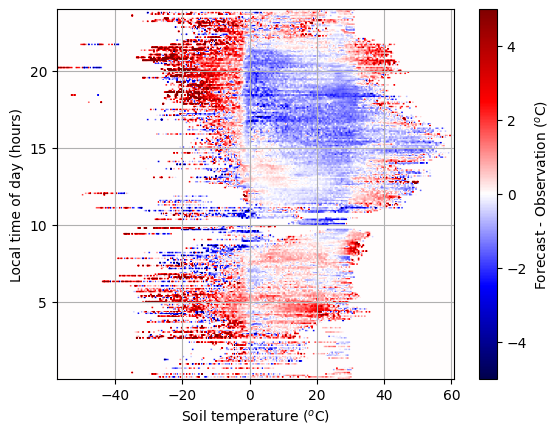

In [10]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                256, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

We see that forecast errors vary with both of these predictors, so we can expect our model to improve if we add soil temperature as a predictor.

Unlike linear regression, random forests are very good at drawing sharp boundaries in the data, so we will not use the additional frozen soil predictor.

Let's train a model with 2 predictors, **note this took 2 minutes for me**

In [11]:
%%time 
# Create the data using a cubic polynomial.
X = np.concatenate([time_of_day_train, soil_temperature_train],axis=-1)

# Create random forest model
reg = RandomForestRegressor(n_estimators = 10, # The number of trees in the forest
                            max_depth = 10, # the maximum depth any tree is allowed to have
                            )
# Train the model using the train sets
reg.fit(X, Y)

CPU times: user 1min, sys: 340 ms, total: 1min
Wall time: 1min 3s


RandomForestRegressor(max_depth=10, n_estimators=10)

In [12]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

X_test = np.concatenate([time_of_day_test, soil_temperature_test
              ],axis=-1)

forecast_corrected = reg.predict(X_test)

##forecast_corrected = linear_model.predict(X_apply)
corrected_mae = metrics.mean_absolute_error(forecast_error_test, forecast_corrected)
corrected_rmse = np.sqrt(metrics.mean_squared_error(forecast_error_test, forecast_corrected))

print('Mean Absolute Error Corrected:', corrected_mae)
print('Root Mean Squared Error Corrected:', corrected_rmse)

print('% Improvement MAE over raw forecast', -(corrected_mae - baseline_mae)/baseline_mae * 100 )
print('% Improvement RMSE over raw forecast', -(corrected_rmse - baseline_rmse)/baseline_rmse * 100 )



Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5283415205305437
Root Mean Squared Error Corrected: 2.1194355375714484
% Improvement MAE over raw forecast 6.373170590054979
% Improvement RMSE over raw forecast 6.059021335987022


### We see a reduction of ~0.1C, or ~6% just from using these two predictors.


### Let's visualise the space 

In [13]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day
x_mesh = np.meshgrid(y_tod,x_st,indexing='ij')
x_mesh = np.stack(x_mesh,axis=-1).reshape((-1,2)) # Combine these predictors together to make the input array.

model_buffer = reg.predict(x_mesh).reshape(buffer.shape) #We need to reshape the output for plotting

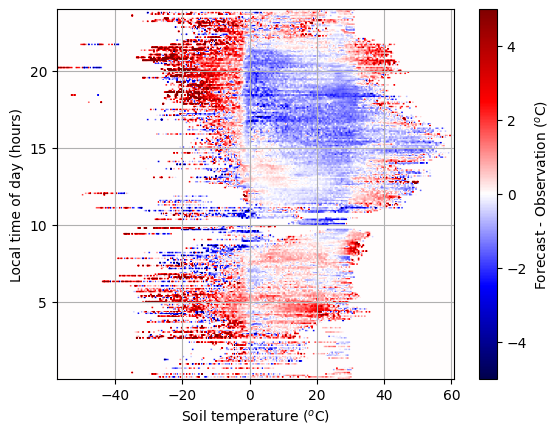

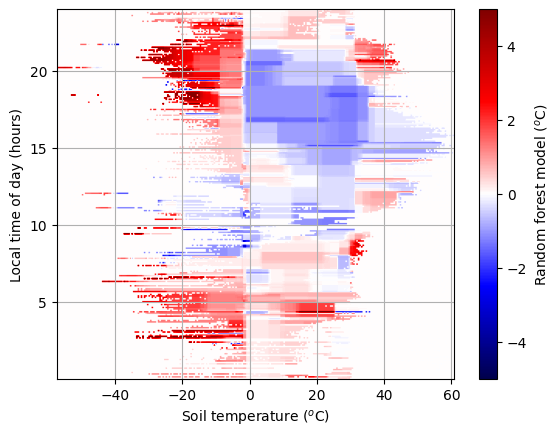

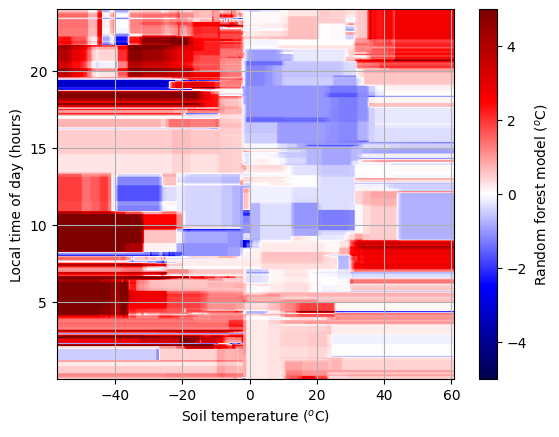

In [14]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model, only over the points where there is data in the test set.
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Random forest model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Random forest model ($^o$C)')

plt.show()

The model constructed with random forests has a complex and blocky shape. These sharp edges denote where one or more tree has a branch point.
However it still produces unlikely results outside of the training dataset (for example the cold soil predictions in the early hours of the morning in the bottom plot). 

How would you improve this model?

### Viz the first decision tree 

In [15]:
!pip install dtreeviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 11.5 MB/s eta 0:00:00


In [23]:
# import dtreeviz

# viz = dtreeviz.model(reg.estimators_[0], X, Y,
#                feature_names=['time_of_day', 'soil_temperature'])

# # viz.save("1st_decision_tree.svg")

# # from google.colab import files
# # files.download("1st_decision_treef.svg")

In [24]:
# viz.view(fancy=False)